# Explore Exercises

These exercises should go in a notebook or script named `explore`.

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [28]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



In [29]:
import matplotlib as mpl


In [30]:
from wrangle import wrangle_311


In [31]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()


In [32]:
df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments



df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only show

- How many different cases are there, by department?


In [33]:
# Joining the data frames:
df = case.join(dept, 'dept_division', 'left').join(source, 'source_id', 'left')

In [34]:
df.show(2, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

In [9]:
case_dept = df.groupby(df.dept_name).count().toPandas()


In [35]:
df.groupby('dept_name').count().show()

+--------------------+------+
|           dept_name| count|
+--------------------+------+
|Animal Care Services|119362|
|                null|   198|
|Solid Waste Manag...|286287|
|Development Services|  1397|
|Trans & Cap Impro...| 97841|
|    Customer Service|  2889|
|        Metro Health|  5313|
|Parks and Recreation| 19964|
|Code Enforcement ...|321984|
|        City Council|    34|
+--------------------+------+



In [10]:
case_dept.sort_values('count', ascending = False).head(10)

,dept_name,count
8,Code Enforcement Services,321984
2,Solid Waste Management,286287
0,Animal Care Services,119362
4,Trans & Cap Improvements,97841
7,Parks and Recreation,19964
6,Metro Health,5313
5,Customer Service,2889
3,Development Services,1397
1,None,198
9,City Council,34


In [11]:
case_dept = case_dept.sort_values(by='count', ascending=False).reset_index(drop=True)


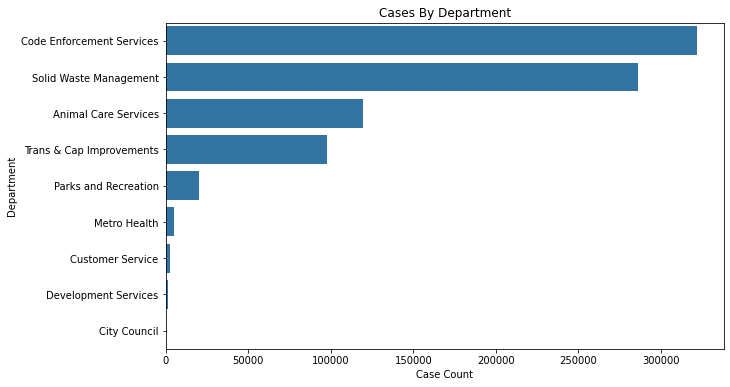

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="dept_name", data=case_dept, color="tab:blue")
plt.title('Cases By Department')
plt.xlabel('Case Count')
plt.ylabel('Department')
plt.show()

- Does the percentage of cases that are late vary by department?


In [13]:
df.createOrReplaceTempView('df')


In [14]:
percent_late = spark.sql('''
SELECT dept_name, AVG(
    CASE 
        WHEN case_late = 'YES' Then 1
        ELSE 0 
    END) * 100 AS pct_case_late
FROM df
GROUP BY dept_name
''').toPandas()

In [15]:
percent_late.sort_values('pct_case_late', ascending = False).head(25)


,dept_name,pct_case_late
5,Customer Service,70.439598
1,None,66.666667
3,Development Services,60.128848
0,Animal Care Services,19.898293
7,Parks and Recreation,19.084352
6,Metro Health,16.073781
2,Solid Waste Management,11.781534
8,Code Enforcement Services,7.909399
4,Trans & Cap Improvements,5.651005
9,City Council,0.000000


In [16]:
percent_late = percent_late.sort_values(by='pct_case_late', ascending=False, ignore_index=True)


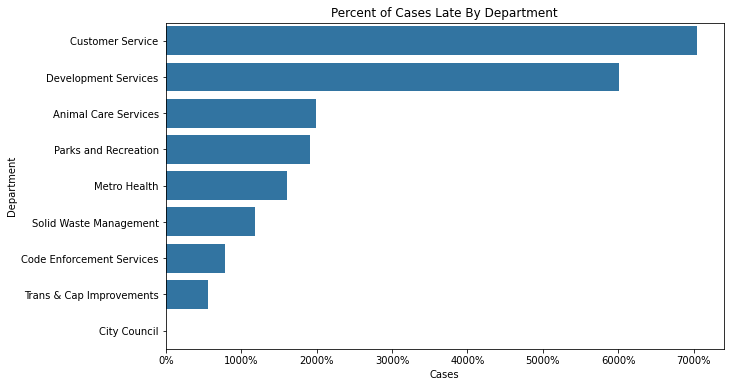

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x="pct_case_late", y="dept_name", data=percent_late, color="tab:blue")
plt.title('Percent of Cases Late By Department')
plt.xlabel('Cases')
plt.ylabel('Department')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0%}".format))
plt.show()

- On average, how late are the late cases by department?


In [18]:
df.show(1, vertical=True, truncate=False)


-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

In [19]:
avg_late_by_dept = spark.sql('''
SELECT dept_name, AVG(num_days_late) AS avg_days_late
FROM df
WHERE case_late = "YES"
GROUP BY dept_name 
''').toPandas()

In [20]:
avg_late_by_dept.sort_values('avg_days_late', ascending = False).head(20)


,dept_name,avg_days_late
1,None,210.892020
5,Customer Service,88.182482
3,Development Services,67.222485
8,Code Enforcement Services,48.085502
0,Animal Care Services,23.446730
7,Parks and Recreation,22.427807
4,Trans & Cap Improvements,10.662950
2,Solid Waste Management,7.147173
6,Metro Health,6.494700


In [21]:
avg_late_by_dept = avg_late_by_dept.sort_values(by='avg_days_late', ascending=False, ignore_index=True)


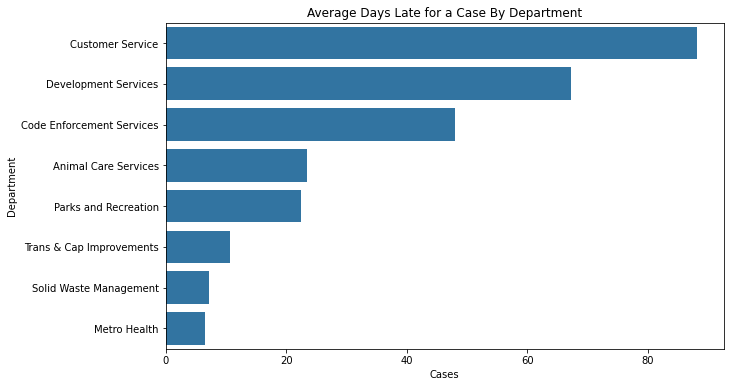

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_days_late", y="dept_name", data=avg_late_by_dept, color="tab:blue")
plt.title('Average Days Late for a Case By Department')
plt.xlabel('Cases')
plt.ylabel('Department')
plt.show()

- What is the service type that is the most late? 


In [23]:
late_service = spark.sql('''
SELECT service_request_type, COUNT(service_request_type) AS num_late_service_req
FROM df
WHERE case_late = "YES"
GROUP BY service_request_type
SORT BY num_late_service_req DESC
LIMIT 10
''').toPandas()

In [24]:
late_service.sort_values('num_late_service_req', ascending = False).head(10)

,service_request_type,num_late_service_req
0,Trapped/Confined Animal,5829
1,No Pickup,5657
2,Aggressive Animal(Non-Critical),5337
3,Animal Neglect,4704
4,Solid Waste Fees and Charges,4500
5,Damaged Cart,4280
6,Aggressive Animal(Critical),4134
7,Front Or Side Yard Parking,3963
8,Bandit Signs,3830
9,Cart Exchange Request,3545


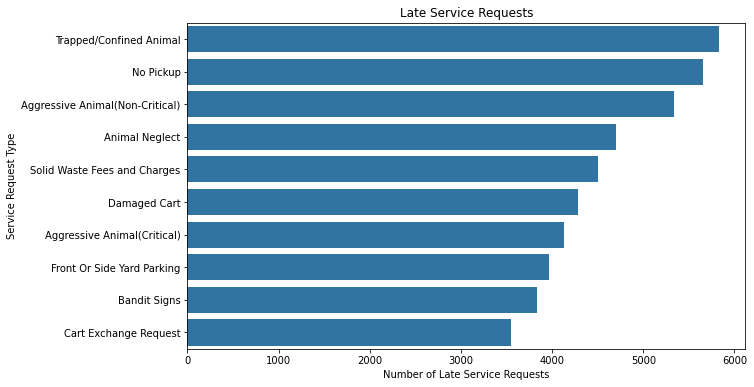

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x="num_late_service_req", y="service_request_type", data=late_service, color="tab:blue")
plt.title('Late Service Requests')
plt.xlabel('Number of Late Service Requests')
plt.ylabel('Service Request Type')
plt.show()

- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.


In [38]:
df.dept_name.value_counts90

Column<'dept_name[value_counts90]'>

In [44]:

df.groupby('dept_division').count().show(50, truncate = False)

+-----------------------------+------+
|dept_division                |count |
+-----------------------------+------+
|Miscellaneous                |46165 |
|Solid Waste                  |816   |
|Field Operations             |119362|
|Streets                      |39193 |
|Waste Collection             |220696|
|Code Enforcement (IntExp)    |2189  |
|Vector                       |546   |
|Dangerous Premise            |15648 |
|311 Call Center              |2889  |
|Brush                        |18610 |
|Dangerous Premise (IntExp)   |36    |
|Traffic Engineering Design   |4398  |
|Code Enforcement (Internal)  |198   |
|District 2                   |3     |
|Signals                      |21095 |
|Engineering Division         |1397  |
|Director's Office Horizontal |521   |
|Storm Water                  |14013 |
|Shops                        |119   |
|Storm Water Engineering      |494   |
|Signs and Markings           |18127 |
|Graffiti (IntExp)            |15154 |
|Tree Crew               

In [46]:
df.groupby('standardized_dept_name').count().show(50, truncate = False)

+------------------------+------+
|standardized_dept_name  |count |
+------------------------+------+
|Solid Waste             |286287|
|Animal Care Services    |119362|
|Trans & Cap Improvements|97841 |
|Parks & Recreation      |19964 |
|Customer Service        |2889  |
|Metro Health            |5313  |
|City Council            |34    |
|DSD/Code Enforcement    |323579|
+------------------------+------+



In [45]:
df.groupby('dept_name').count().show(50, truncate = False)

+-------------------------+------+
|dept_name                |count |
+-------------------------+------+
|Animal Care Services     |119362|
|null                     |198   |
|Solid Waste Management   |286287|
|Development Services     |1397  |
|Trans & Cap Improvements |97841 |
|Customer Service         |2889  |
|Metro Health             |5313  |
|Parks and Recreation     |19964 |
|Code Enforcement Services|321984|
|City Council             |34    |
+-------------------------+------+



In [41]:
df.show(1, vertical=True, truncate=False)


-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

In [47]:
(
    df.filter(df.standardized_dept_name == 'DSD/Code Enforcement')
    .groupby('service_request_type')
    .count()
    .sort(col('count').desc())
    .show()
)

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|Overgrown Yard/Trash|66403|
|        Bandit Signs|32968|
|Front Or Side Yar...|28920|
|Junk Vehicle On P...|21649|
|Alley-Way Mainten...|20293|
|Right Of Way/Side...|17836|
|Vacant Lot/Overgr...| 9497|
|Minimum Housing-O...| 8617|
|Graffiti: Private...| 8525|
|Minimum Housing-T...| 8104|
|Dang. Premises/CL...| 8004|
|"Vacant Lot-Priva...| 7875|
|    Brush Violations| 7530|
|    Permits Building| 6950|
|Vacant House Over...| 6278|
|  Graffiti: Building| 4572|
|Low Hanging Limbs...| 4107|
|Graffiti Public P...| 4104|
|CPS Energy Wood P...| 3501|
|Zoning Business i...| 2773|
+--------------------+-----+
only showing top 20 rows



- Does whether or not its a weekend matter for when a case is opened/closed?


In [48]:
fmt = "M/d/yy"

open_close = (
    df.select('case_opened_date', 'case_closed_date')
    .withColumn('open_date', to_date('case_opened_date'))
    .withColumn('close_date', to_date('case_closed_date'))
    .drop('case_opened_date').drop('case_closed_date')
)

opened_weekend_count = (
    open_close.withColumn("opened_weekend", 
                          date_format("open_date", 'EEE')
                          .isin(["Sat", "Sun"]))
    .groupby('opened_weekend')
    .count()
)

closed_weekend_count = (
    
    open_close.withColumn("closed_weekend", 
                          date_format("close_date", 'EEE')
                          .isin(["Sat", "Sun"]))
    .groupby('closed_weekend')
    .count()
)

In [49]:
opened_weekend_count.show()


+--------------+------+
|opened_weekend| count|
+--------------+------+
|          null|855269|
+--------------+------+



In [50]:
closed_weekend_count.show()


+--------------+------+
|closed_weekend| count|
+--------------+------+
|          null|855269|
+--------------+------+



- On average, how many cases are opened a day for the Customer Service department?


- Does the number of service requests for the solid waste department vary by day of the week?